# Visualization

In [140]:
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.animation import FuncAnimation, FFMpegWriter
import numpy as np
import spheroidal
from tqdm import tqdm

In [88]:
u = np.linspace(0, 2 * np.pi, 200)
v = np.linspace(0, np.pi, 100)
phi, theta = np.meshgrid(u, v)

# make sphere
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

cmap = matplotlib.colors.ListedColormap(['tab:red', 'tab:green'])
norm = matplotlib.colors.BoundaryNorm([-1, 0, 1], ncolors=2)
ls = matplotlib.colors.LightSource(azdeg=30, altdeg=0)

## Single Harmonic

In [145]:
s, l, m, gamma = 0, 3, 2, 5j

plt.style.use('dark_background')

### Plot

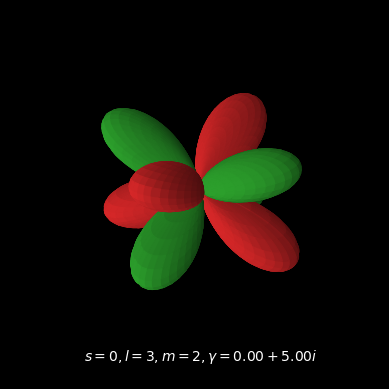

In [146]:
r = np.real(spheroidal.harmonic(s,l,m,gamma)(theta,phi))
sign = np.sign(r)
r = abs(r)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# Plot the surface
surface = ax.plot_surface(r * x, r * y, r * z, facecolors=cmap(norm(sign)), rstride=2, cstride=2,lightsource=ls)

# add text with parameters and time
text = ax.text2D(
    0.2,
    0.05,
    f"$s = {s}, l = {l}, m = {m}, \gamma = {np.real(gamma):.2f} + {np.imag(gamma):.2f}i$",
    transform=ax.transAxes,
            )

ax.set_aspect("equal")
ax.axis('off')

plt.show()

### Animation

In [147]:
length = 10
fps = 24

g = lambda t: 10*np.sin(np.pi*t/5)**2*(1 if t<5 else 1j)

In [ ]:
num_frames = length * fps
deg_per_frame = 360 / num_frames

# start progress bar
with tqdm(total=num_frames, ncols=80) as pbar:
    def draw_frame(i):
        # update progress bar
        pbar.update(1)

        # rotate light source
        ls.azdeg = 30-i*deg_per_frame
        # rotate camera
        ax.view_init(30, i*deg_per_frame)
        ax.set_aspect("equal")

        # recompute harmonic with updated spheroidicity
        r = np.real(spheroidal.harmonic(s,l,m,g(i/fps))(theta,phi))
        sign = np.sign(r)
        r = abs(r)

        # update plot
        global surface
        surface.remove()
        surface = ax.plot_surface(r * x, r * y, r * z, facecolors=cmap(norm(sign)), rstride=3, cstride=3,lightsource=ls)

        # update text
        text.set_text(f"$s = {s}, l = {l}, m = {m}, \gamma = {np.real(g(i/fps)):.2f} + {np.imag(g(i/fps)):.2f}i$")

    # save to file
    ani = FuncAnimation(fig, draw_frame, num_frames)
    FFwriter = FFMpegWriter(fps=fps)
    ani.save("single_harmonic.mp4", writer=FFwriter)
    
    # close figure so it doesn't show up in notebook
    plt.close(fig)

## All Harmonics

### Plot

In [151]:
s = -2
gamma = 1.5
l_min = 2
l_max = 3

plt.style.use('default')

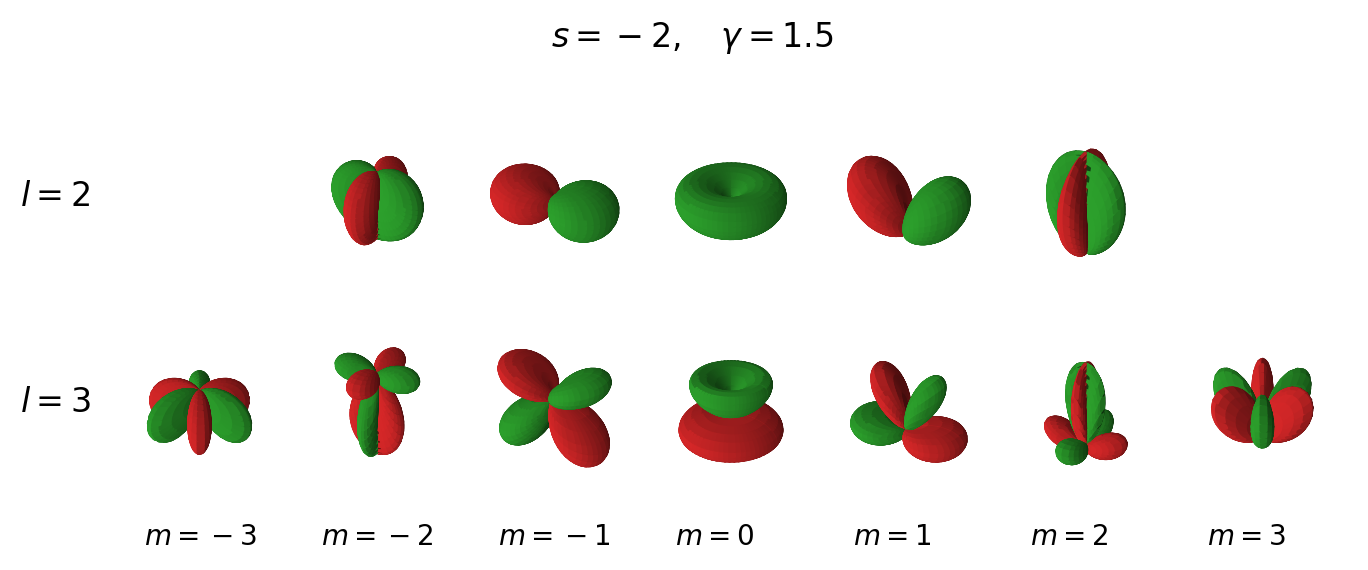

In [152]:
fig, ax = plt.subplots(l_max-l_min+1, 2*l_max+1, subplot_kw=dict(projection='3d'), figsize=(8, 4), dpi=200)

l_vals = np.arange(l_min, l_max + 1)

surfaces = [] # keep track of surfaces so we can update them in the animation

for i,l in enumerate(l_vals):

    m_vals = np.arange(-l, l + 1)

    for j,m in enumerate(m_vals):
        # compute harmonic
        r = np.real(spheroidal.harmonic(s,l,m,gamma,num_terms=20)(theta,phi))
        sign = np.sign(r)
        r = abs(r)

        # plot the surface
        surfaces.append(ax[i,j+l_max-l].plot_surface(r * x, r * y, r * z, facecolors=cmap(norm(sign)), rstride=3, cstride=3,lightsource=ls))

        # add m labels to last row
        if l == l_vals[-1]:
            ax[i,j+l_max-l].text2D(
                0.2,
                -0.25,
                (f"$m = {m}$" if m >= 0 else f"$m=-{abs(m)}$"),
                transform=ax[i,j+l_max-l].transAxes,
                #size="large",
                        )
                        
# add l labels
for i,l in enumerate(l_vals):
    ax[i,0].text2D(
        -0.5,
        0.5,
        f"$l = {l}$",
        transform=ax[i,0].transAxes,
        size="large",
                )

title = ax[0,l_max].text2D(-0.5,1.4,f"$s = {s},\quad \gamma = {gamma}$",size="large",transform=ax[0,l_max].transAxes)

# remove axes and facecolor and set equal aspect ratio for all subplots           
for axes in ax.flatten():
    axes.axis('off')
    axes.set_aspect('equal')
    axes.set_facecolor('none')

# adjust spacing between subplots
fig.subplots_adjust(wspace=0, hspace=-0.5)

### Animation

In [ ]:
length = 10
fps = 24

g = lambda t: 5*np.sin(np.pi*t/5)**2*(1 if t<5 else 1j)

In [ ]:
num_frames = length * fps
deg_per_frame = 360 / num_frames

# start progress bar
with tqdm(total=num_frames, ncols=80) as pbar:
    def draw_frame(i):
        # update progress bar
        pbar.update(1)

        global title
        global ls

        # rotate light source
        ls.azdeg = 30-i*deg_per_frame
        title.set_text(f"$s = {s}, \quad \gamma = {np.real(g(i/fps)):.2f} + {np.imag(g(i/fps)):.2f}i$")

        # rotate plots
        for axes in ax.flatten():
            axes.view_init(30, i*deg_per_frame)
            axes.set_aspect("equal")

        k = 0
    
        for l in l_vals:

            m_vals = np.arange(-l, l + 1)

            for j,m in enumerate(m_vals):
                # recompute harmonic with updated spheroidicity
                r = np.real(spheroidal.harmonic(s,l,m,g(i/fps),num_terms=25)(theta,phi))
                sign = np.sign(r)
                r = abs(r)
                
                # Plot the surface
                global surfaces
                surfaces[k].remove()
                surfaces[k] = ax[l-l_min,j+l_max-l].plot_surface(r * x, r * y, r * z, facecolors=cmap(norm(sign)), rstride=3, cstride=3,lightsource=ls)
                k += 1

    # save to file
    ani = FuncAnimation(fig, draw_frame, num_frames)
    FFwriter = FFMpegWriter(fps=fps)
    ani.save("all_harmonics.mp4", writer=FFwriter)

    # close figure so it doesn't show up in notebook
    plt.close(fig)